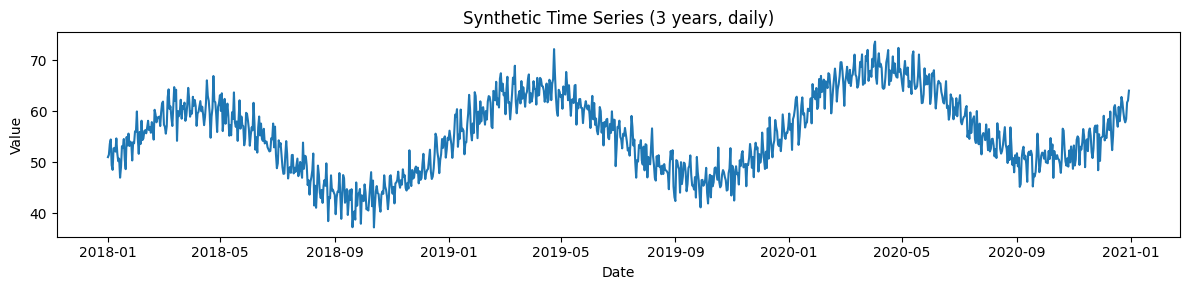

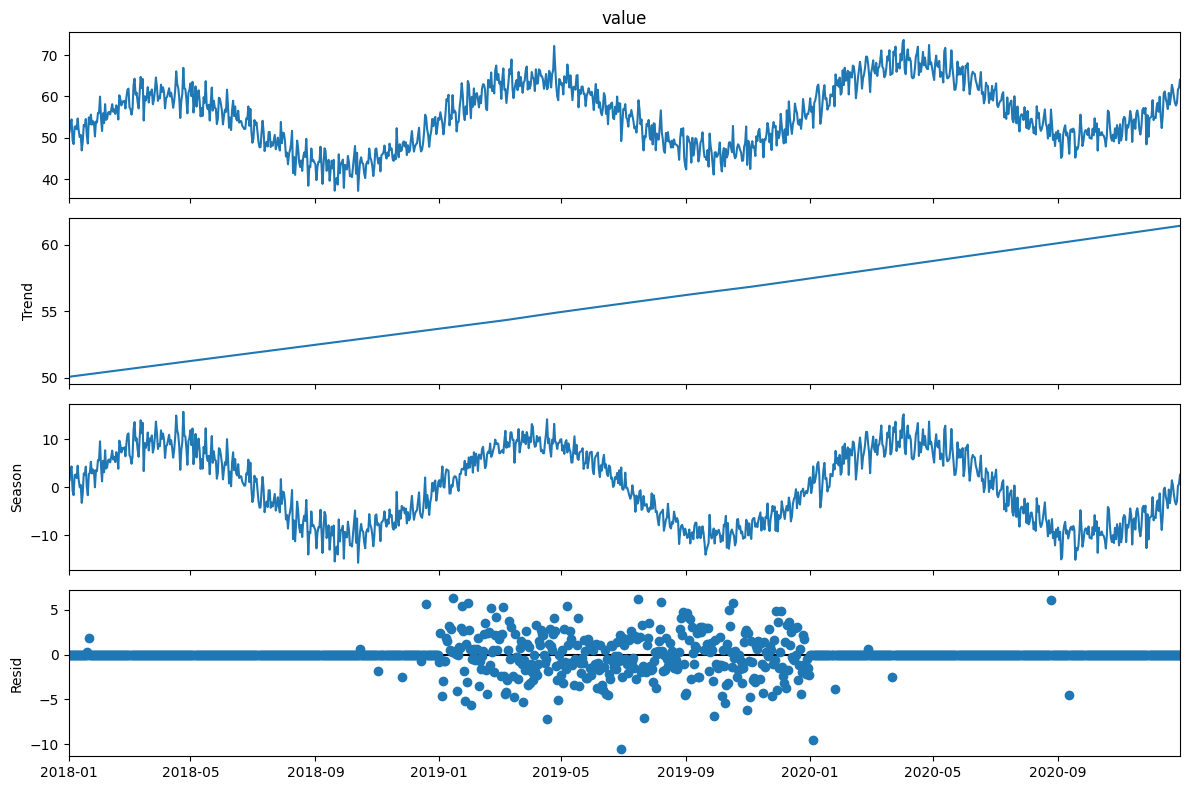

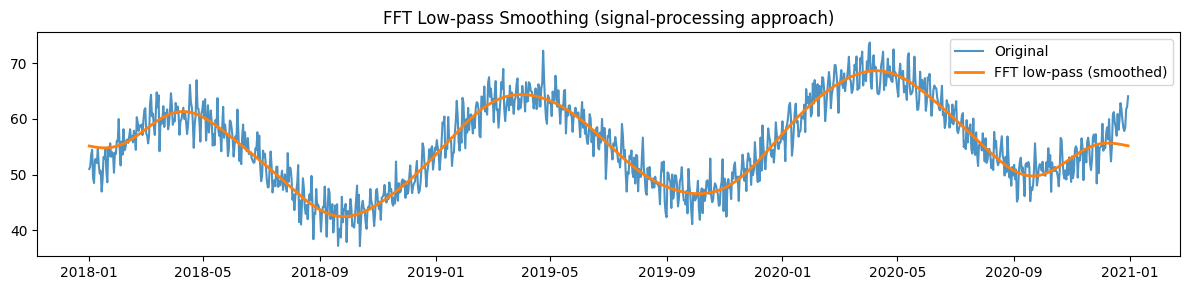

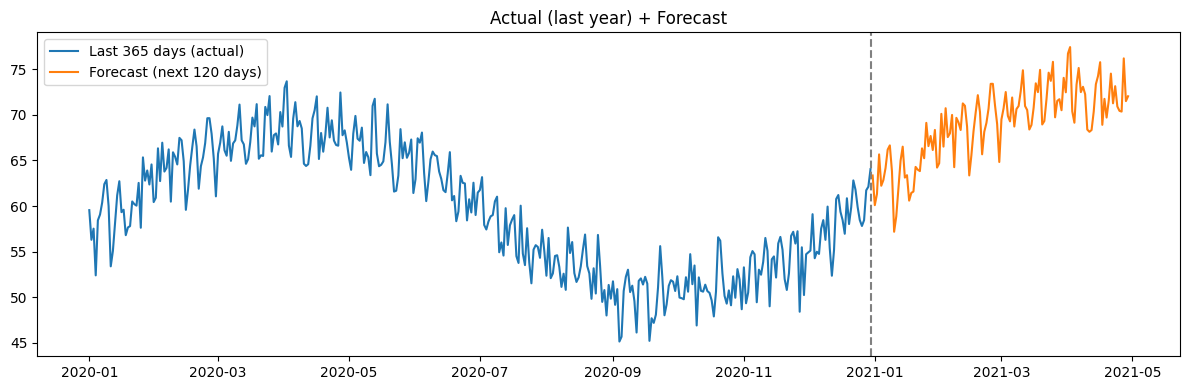

Backtest RMSE on last 120 days: 2.9782


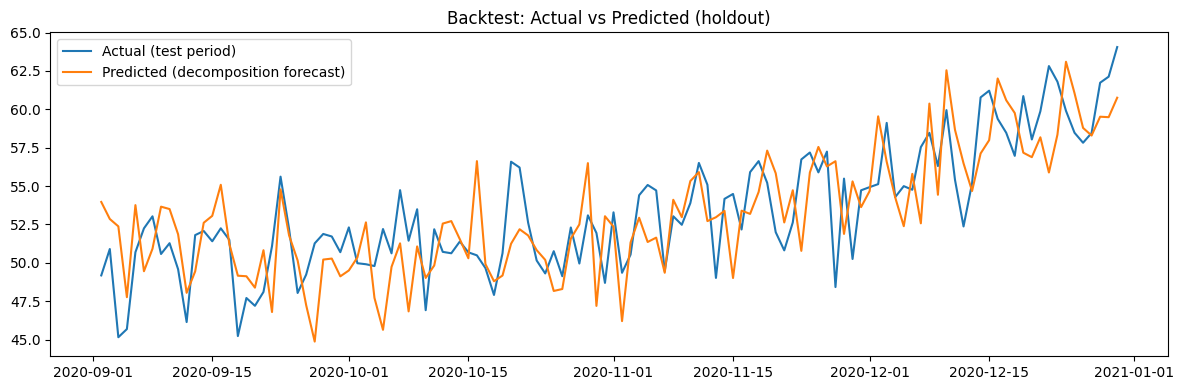


Holdout sample (first 10 rows):
               actual  predicted     error
2020-09-02  49.175794  53.961069 -4.785276
2020-09-03  50.896036  52.851201 -1.955165
2020-09-04  45.147828  52.370824 -7.222996
2020-09-05  45.678802  47.758238 -2.079436
2020-09-06  50.689397  53.755251 -3.065854
2020-09-07  52.242278  49.447700  2.794579
2020-09-08  53.026405  50.913734  2.112671
2020-09-09  50.571602  53.654890 -3.083288
2020-09-10  51.274656  53.499061 -2.224406
2020-09-11  49.576711  51.852977 -2.276266

Future forecast (first 10 rows):
2020-12-31    63.356976
2021-01-01    60.103017
2021-01-02    61.321760
2021-01-03    65.668468
2021-01-04    62.230374
2021-01-05    62.862057
2021-01-06    64.173492
2021-01-07    66.193636
2021-01-08    66.657413
2021-01-09    63.799586
Freq: D, Name: forecast, dtype: float64

Saved combined actual+forecast CSV to: /content/decomposition_forecast_output.csv

--- Summary ---
1) Decompose the series with STL to get trend, seasonal, residual.
2) Optionally

In [1]:
"""
Time Series Forecasting using Signal-Processing Decomposition Techniques
- STL decomposition (trend / seasonal / residual)
- FFT low-pass smoothing (optional)
- Component forecasting:
    * Trend: linear extrapolation (numpy.polyfit)
    * Seasonal: seasonal-naive (repeat last yearly cycle)
    * Residual: ARIMA(1,0,0) on residuals (fallback to mean if ARIMA fails)
- Backtesting (holdout) and plotting
Requirements: numpy, pandas, matplotlib, statsmodels
Install if needed: pip install numpy pandas matplotlib statsmodels
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import os

# ---------------------------
# Helpers
# ---------------------------
def generate_synthetic_series(n_days=365*3, seed=42):
    """Generate synthetic daily time series with trend + yearly + weekly + noise."""
    np.random.seed(seed)
    n = n_days
    date_index = pd.date_range(start='2018-01-01', periods=n, freq='D')
    trend = 0.01 * np.arange(n)                          # small linear trend
    seasonal_yearly = 10 * np.sin(2 * np.pi * np.arange(n) / 365.25)
    weekly = 2 * np.sin(2 * np.pi * np.arange(n) / 7)
    noise = np.random.normal(scale=2.0, size=n)
    y = 50 + trend + seasonal_yearly + weekly + noise
    return pd.Series(y, index=date_index, name='value')

def fft_lowpass_filter(series, cutoff_freq_ratio=0.02):
    """Simple FFT low-pass filter. cutoff_freq_ratio between 0 and 1 (smaller -> smoother)."""
    x = series.values
    n = len(x)
    fft_coef = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n)
    cutoff = cutoff_freq_ratio * freqs.max()
    mask = freqs <= cutoff
    fft_filt = fft_coef * mask
    x_smooth = np.fft.irfft(fft_filt, n=n)
    return pd.Series(x_smooth, index=series.index)

def forecast_components_stl(ts, stl_result, forecast_horizon=120, season_length=365):
    """
    Given ts (pd.Series) and stl_result (statsmodels STL results),
    forecast next `forecast_horizon` days by component:
      - trend: linear fit (polyfit degree=1)
      - seasonal: repeat last season_length days
      - resid: ARIMA(1,0,0) on residuals (fallback to mean or zeros)
    Returns forecast_series (pd.Series).
    """
    trend_comp = stl_result.trend
    seasonal_comp = stl_result.seasonal
    resid_comp = stl_result.resid

    # future index
    last_date = ts.index[-1]
    future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

    # Trend forecast using linear polynomial fit
    x = np.arange(len(trend_comp))
    # polyfit returns [slope, intercept] for deg=1
    coef = np.polyfit(x, trend_comp.values, deg=1)
    future_x = np.arange(len(trend_comp), len(trend_comp) + forecast_horizon)
    trend_forecast = np.polyval(coef, future_x)

    # Seasonal forecast: repeat last year's seasonal cycle (or seasonal mean if not enough data)
    if len(seasonal_comp) >= season_length:
        last_season = seasonal_comp[-season_length:].values
        repeats = int(np.ceil(forecast_horizon / season_length))
        seasonal_future = np.tile(last_season, repeats)[:forecast_horizon]
    else:
        seasonal_future = np.full(forecast_horizon, seasonal_comp.mean())

    # Residual forecast using ARIMA(1,0,0) if possible
    resid = resid_comp.dropna()
    if len(resid) >= 10:
        try:
            arima_model = ARIMA(resid, order=(1,0,0)).fit()
            resid_forecast = arima_model.forecast(steps=forecast_horizon)
            # Ensure index alignment
            resid_forecast = pd.Series(resid_forecast, index=future_index).values
        except Exception as e:
            # fallback to mean residual
            resid_forecast = np.full(forecast_horizon, resid.mean())
    else:
        resid_forecast = np.zeros(forecast_horizon)

    forecast_values = trend_forecast + seasonal_future + resid_forecast
    forecast_series = pd.Series(forecast_values, index=future_index, name='forecast')
    return forecast_series

def backtest_decomposition(ts, backtest_h=120, season_length=365):
    """
    Backtest decomposition forecasting by using all data except the last backtest_h days as train,
    forecasting those last days and returning actual vs predicted series and RMSE.
    """
    train = ts[:-backtest_h]
    test = ts[-backtest_h:]

    stl_train = STL(train, period=season_length, robust=True).fit()
    pred_bt = forecast_components_stl(train, stl_train, forecast_horizon=backtest_h, season_length=season_length)

    # align predicted series index with test
    pred_bt = pred_bt[:len(test)]
    pred_bt.index = test.index

    mse = np.mean((test.values - pred_bt.values)**2)
    rmse = np.sqrt(mse)
    return test, pred_bt, rmse

# ---------------------------
# Main flow
# ---------------------------
def main():
    # 1) Generate data
    ts = generate_synthetic_series(n_days=365*3, seed=42)

    # 2) Plot raw series
    plt.figure(figsize=(12,3))
    plt.plot(ts)
    plt.title('Synthetic Time Series (3 years, daily)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

    # 3) STL decomposition
    season_length = 365
    stl = STL(ts, period=season_length, robust=True)
    stl_res = stl.fit()

    # Plot decomposition
    fig = stl_res.plot()
    fig.set_size_inches(12,8)
    plt.tight_layout()
    plt.show()

    # 4) FFT smoothing example
    smoothed = fft_lowpass_filter(ts, cutoff_freq_ratio=0.02)
    plt.figure(figsize=(12,3))
    plt.plot(ts, label='Original', alpha=0.8)
    plt.plot(smoothed, label='FFT low-pass (smoothed)', linewidth=2)
    plt.title('FFT Low-pass Smoothing (signal-processing approach)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5) Forecast next horizon by components
    forecast_horizon = 120
    forecast_series = forecast_components_stl(ts, stl_res, forecast_horizon=forecast_horizon, season_length=season_length)

    # Plot last 365 days + forecast
    plt.figure(figsize=(12,4))
    plt.plot(ts[-365:], label='Last 365 days (actual)')
    plt.plot(forecast_series, label=f'Forecast (next {forecast_horizon} days)')
    plt.axvline(ts.index[-1], linestyle='--', color='gray')
    plt.legend()
    plt.title('Actual (last year) + Forecast')
    plt.tight_layout()
    plt.show()

    # 6) Backtest (holdout)
    test, pred_bt, rmse = backtest_decomposition(ts, backtest_h=forecast_horizon, season_length=season_length)
    print(f"Backtest RMSE on last {forecast_horizon} days: {rmse:.4f}")

    # Plot backtest actual vs predicted
    plt.figure(figsize=(12,4))
    plt.plot(test, label='Actual (test period)')
    plt.plot(pred_bt, label='Predicted (decomposition forecast)')
    plt.legend()
    plt.title('Backtest: Actual vs Predicted (holdout)')
    plt.tight_layout()
    plt.show()

    # 7) Comparison DataFrame (first 10 rows)
    compare_df = pd.DataFrame({
        'actual': test.values,
        'predicted': pred_bt.values,
        'error': test.values - pred_bt.values
    }, index=test.index)
    print("\nHoldout sample (first 10 rows):")
    print(compare_df.head(10))

    # 8) Future forecast snippet
    print("\nFuture forecast (first 10 rows):")
    print(forecast_series.head(10))

    # 9) Save actual + forecast to CSV
    # We'll save actual series and future forecast in one CSV with columns: date, type, value
    actual_df = ts.reset_index()
    actual_df.columns = ['date', 'value']
    actual_df['type'] = 'actual'
    forecast_df = forecast_series.reset_index()
    forecast_df.columns = ['date', 'value']
    forecast_df['type'] = 'forecast'
    out_df = pd.concat([actual_df, forecast_df], ignore_index=True)
    save_path = os.path.join(os.getcwd(), 'decomposition_forecast_output.csv')
    out_df.to_csv(save_path, index=False)
    print(f"\nSaved combined actual+forecast CSV to: {save_path}")

    # 10) Short textual summary (useful for students)
    print("\n--- Summary ---")
    print("1) Decompose the series with STL to get trend, seasonal, residual.")
    print("2) Optionally smooth using FFT low-pass to remove high-frequency noise.")
    print("3) Forecast components separately (trend: linear, seasonal: seasonal-naive, residual: ARIMA).")
    print("4) Recombine component forecasts to produce the final forecast and evaluate with backtesting.")

if __name__ == "__main__":
    main()
